In [1]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import pipeline

# Check if sentiment pipeline loads
sentiment_pipeline = pipeline("sentiment-analysis")

print("All packages loaded successfully ✅")


c:\Users\hp\Desktop\kifiya\fintech-review-analysis\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
c:\Users\hp\Desktop\kifiya\fintech-review-analysis\venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\hp\.cache\huggingface\hub\models--distilbert--distilbert-base-uncased-finetuned-sst-2-english. Caching files will still work but in a degraded version tha

All packages loaded successfully ✅


In [3]:
from tqdm.auto import tqdm  # ← works in both console and notebook
import time

for i in tqdm(range(10)):
    time.sleep(0.1)


100%|██████████| 10/10 [00:01<00:00,  9.25it/s]


In [4]:
from transformers import pipeline

# Load the sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

# Example usage
result = sentiment_pipeline("The app is amazing!")
print(result)


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


[{'label': 'POSITIVE', 'score': 0.9998750686645508}]


In [6]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize the analyzer
analyzer = SentimentIntensityAnalyzer()

# Now apply it to your DataFrame
df['vader_score'] = df['review'].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])
df['sentiment'] = df['vader_score'].apply(lambda score: 'positive' if score > 0.05 else 'negative' if score < -0.05 else 'neutral')


In [7]:
import pandas as pd

df = pd.read_csv("./data/cleaned_reviews.csv")

# Example for HuggingFace
df['sentiment'] = df['review'].apply(lambda x: sentiment_pipeline(x)[0]['label'])

# Or for VADER
df['vader_score'] = df['review'].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])
df['sentiment'] = df['vader_score'].apply(lambda score: 'positive' if score > 0.05 else 'negative' if score < -0.05 else 'neutral')


In [8]:
df.to_csv('./data/sentiment_reviews.csv', index=False)


In [9]:
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')
from nltk.corpus import stopwords

# Step 1: Prepare stopwords and clean text
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # remove punctuation
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['cleaned_review'] = df['review'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# Step 2: TF-IDF to extract top keywords per bank
banks = df['bank'].unique()
bank_keywords = {}

for bank in banks:
    reviews = df[df['bank'] == bank]['cleaned_review'].tolist()
    
    vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=30)  # unigrams and bigrams
    tfidf_matrix = vectorizer.fit_transform(reviews)
    
    feature_array = vectorizer.get_feature_names_out()
    tfidf_scores = tfidf_matrix.sum(axis=0).A1
    keywords = sorted(zip(feature_array, tfidf_scores), key=lambda x: x[1], reverse=True)[:10]
    
    bank_keywords[bank] = [kw for kw, score in keywords]


In [11]:

# Example keyword groupings
themes = {
    "Account Access": ['login', 'password', 'reset', 'sign', 'register'],
    "Transaction Performance": ['transfer', 'fail', 'delay', 'processing'],
    "App Usability": ['interface', 'navigation', 'crash', 'slow', 'update'],
    "Customer Support": ['support', 'help', 'response', 'call'],
    "Feature Requests": ['loan', 'wallet', 'bill', 'new', 'add']
}

# Assign themes to keywords
def assign_theme(keyword):
    for theme, word_list in themes.items():
        if any(kw in keyword for kw in word_list):
            return theme
    return "Other"

# Apply this to keyword list for each bank
bank_themes = {}
for bank, keywords in bank_keywords.items():
    grouped = {}
    for kw in keywords:
        theme = assign_theme(kw)
        grouped.setdefault(theme, []).append(kw)
    bank_themes[bank] = grouped


In [12]:
# Save sentiment + theme assignment
df.to_csv("./data/reviews_with_sentiment.csv", index=False)


In [13]:
# Ensure rating column exists and is numeric
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

# Group sentiment by bank and rating
sentiment_summary = df.groupby(['bank', 'rating', 'sentiment']).size().unstack(fill_value=0)

# Show summary
print(sentiment_summary)


sentiment      negative  neutral  positive
bank   rating                             
BOA    1             79       48        35
       2              2        5         4
       3              3       10        12
       4              0        7         7
       5              3       51        78
CBE    1             16       15        13
       2              4        4         5
       3              1       12         4
       4              2       14        19
       5              2       55       156
Dashen 1             14        8        11
       2              6        6         4
       3              0        4         7
       4              2        8        12
       5              3       50       231


In [14]:
# Display top keywords per theme per bank
for bank, theme_dict in bank_themes.items():
    print(f"\n=== {bank} ===")
    for theme, keywords in theme_dict.items():
        print(f"\nTheme: {theme}")
        print("Top Keywords:", ", ".join(keywords))
        
        # Show 1 example review for this theme
        example = df[df['cleaned_review'].str.contains('|'.join(keywords), na=False)].head(1)
        if not example.empty:
            print("Example review:", example['review'].values[0])



=== CBE ===

Theme: Other
Top Keywords: app, good, best, nice, cbe, bank, like, great, easy, screenshot
Example review: Best Mobile Banking app ever

=== BOA ===

Theme: Other
Top Keywords: app, good, bank, work, boa, use, working, please, best, dont
Example review: Best Mobile Banking app ever

=== Dashen ===

Theme: Other
Top Keywords: app, dashen, best, good, banking, super, bank, one, use, amazing
Example review: Best Mobile Banking app ever


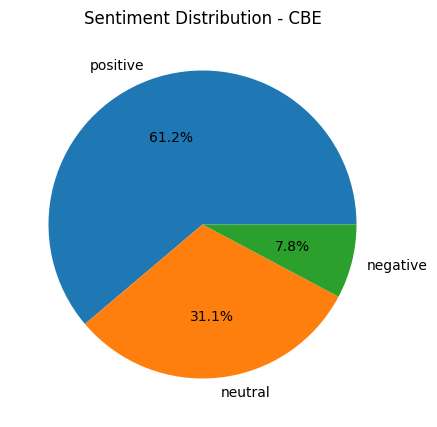

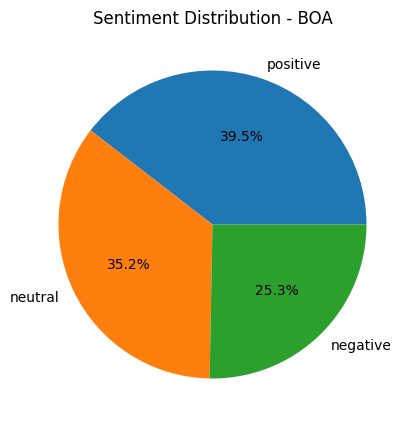

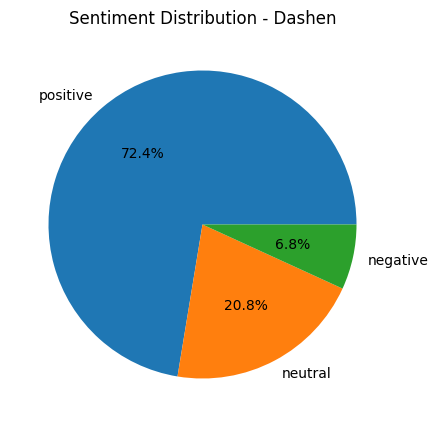

In [16]:
import matplotlib.pyplot as plt

# Pie chart of sentiment distribution per bank
for bank in df['bank'].unique():
    counts = df[df['bank'] == bank]['sentiment'].value_counts()
    plt.figure(figsize=(5, 5))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%')
    plt.title(f"Sentiment Distribution - {bank}")
    plt.show()


In [17]:
# Save final dataset with sentiment and cleaned text
df.to_csv("./data/final_reviews_sentiment_themes.csv", index=False)
